# Pacotes úteis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore');

from statsmodels.tsa.seasonal import seasonal_decompose as stl
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.tree import DecisionTreeRegressor as dt
from itertools import product
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX as sr
from numpy import log
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(12345)

from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score as crv

from math import log

import statsmodels.api as sm

# EDA



## Carregando o dataset

In [2]:
df = pd.read_excel("DadosBA.xlsx", sheet_name = None)
df = pd.concat([df['2018'],df['2019'],df['2020']]) # Concatenar data from 2018 and 2020 dataframes
# df = pd.concat([df['2020']]) # Concatenar data from 2018 and 2020 dataframes
df.set_index('Timestamp', inplace = True) #set timestamps as index
df


,BAIRRO ALTO - / FREQ B1,BAIRRO ALTO - / FREQ B2,BAIRRO ALTO - / FREQ B3,BAIRRO ALTO - LT01 / NÍVEL,BAIRRO ALTO - FT01 / ENT IRAI,BAIRRO ALTO - FT02 / GBAL,BAIRRO ALTO - FT03 / RBAL,BAIRRO ALTO - PT01 / SUCÇÃO,BAIRRO ALTO - PT02 / RBAL
Timestamp,,,,,,,,,
2018-01-01 00:00:00,39.716118,0,0,4.027903,270.285187,76.920532,61.992577,5.232423,13.961227
2018-01-01 01:00:00,40.692509,0,0,4.241524,268.635803,83.023201,66.538521,5.431031,13.961227
2018-01-01 02:00:00,34.512108,0,0,4.352295,0,82.35186,57.269573,5.555567,11.049756
2018-01-01 03:00:00,33.531471,0,0,4.136808,0,69.360985,52.244926,5.358496,11.115347
2018-01-01 04:00:00,33.191261,0,0,3.947308,0,59.742775,49.71859,5.184939,11.180938
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,57.988792,46.797836,0,3.669613,0.115741,149.436783,121.814819,4.499011,23.046875
2020-12-31 20:00:00,57.988792,47.061192,0,3.221217,0.115741,151.018051,117.933388,4.070826,23.046875
2020-12-31 21:00:00,0,45.869583,57.988792,2.803498,0.115741,129.294189,106.692932,3.714235,21.976273


In [3]:
filtro = (df.index.year>=2018)
df = df[filtro]
filtro = (df.index.year<=2020)
df = df[filtro]
# filtro = (df.index.hour>=18)
# df = df[filtro]
# filtro = (df.index.hour<=21)
# df = df[filtro]

hora = '24h'

df.isna().any() # verifique se não há valores NAN
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
                        'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
                        'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
                        'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
                        'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA- FT01',
                        'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
                        'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
                        'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
                        'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})
df

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02
Timestamp,,,,,,,,,
2018-01-01 00:00:00,39.716118,0,0,4.027903,270.285187,76.920532,61.992577,5.232423,13.961227
2018-01-01 01:00:00,40.692509,0,0,4.241524,268.635803,83.023201,66.538521,5.431031,13.961227
2018-01-01 02:00:00,34.512108,0,0,4.352295,0,82.35186,57.269573,5.555567,11.049756
2018-01-01 03:00:00,33.531471,0,0,4.136808,0,69.360985,52.244926,5.358496,11.115347
2018-01-01 04:00:00,33.191261,0,0,3.947308,0,59.742775,49.71859,5.184939,11.180938
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,57.988792,46.797836,0,3.669613,0.115741,149.436783,121.814819,4.499011,23.046875
2020-12-31 20:00:00,57.988792,47.061192,0,3.221217,0.115741,151.018051,117.933388,4.070826,23.046875
2020-12-31 21:00:00,0,45.869583,57.988792,2.803498,0.115741,129.294189,106.692932,3.714235,21.976273


In [4]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

# 24 horas

df = df.resample('24h').mean()
# df2 = df.resample('24h', offset = "19h").mean()
# df3 = df.resample('24h', offset = "20h").mean()
# df4 = df.resample('24h', offset = "21h").mean()
df.shape

(1096, 9)

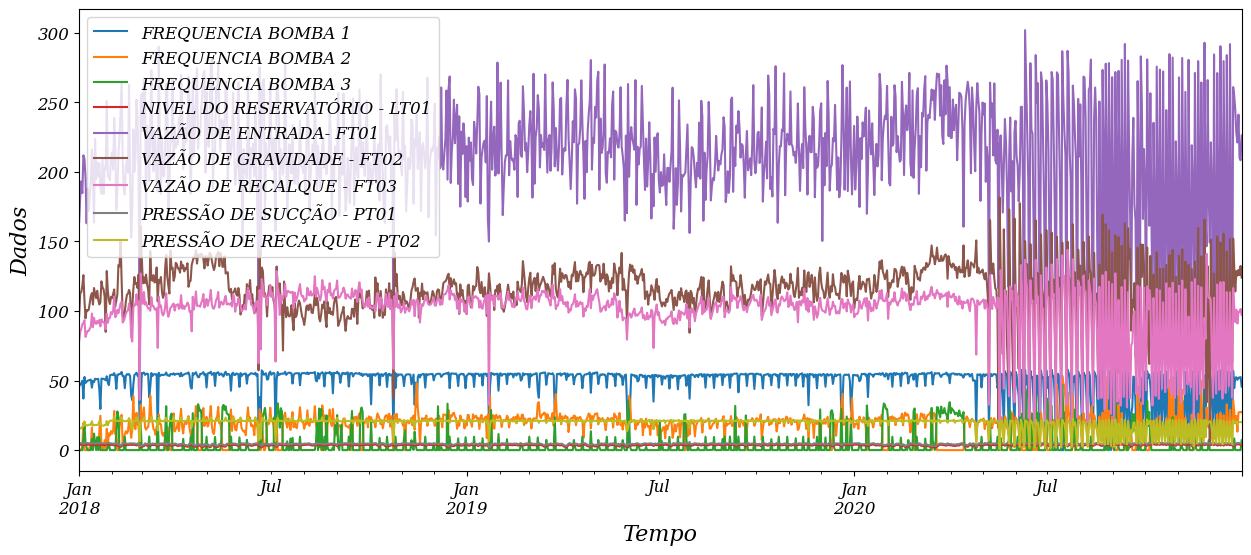

In [5]:

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
# gráfico de linha
df.plot(figsize = (15,6))
plt.xlabel('Tempo', fontsize = 16)
plt.ylabel("Dados", fontsize = 16)
plt.legend(loc = 2)
plt.savefig("dados todo.png", dpi=300)
plt.show()


In [7]:
# df2.FT03.hist()
# plt.xlabel('Tempo', fontsize = 16)
# plt.ylabel('FT03 M³/h', fontsize = 16)

# Treino, test e validação


In [8]:
#%% Divide os dados em treinamento, validação e teste
# 70% para treinamento e validação (18.414 amostras) e 30% para teste (7.892 amostras)
# Das 18.414 amostras, 80% para treinamento (14.731 amostras) e 20% para validação (3.683 amostras)

# thresholds
trn_samples = int((len(df)*70/100)*(80/100))
vld_samples = int((len(df)*70/100)*(20/100))
tst_samples = int((len(df)*30/100))

trn = df.iloc[:trn_samples]
vld = df.iloc[trn_samples:trn_samples+vld_samples]
tst = df.iloc[trn_samples+vld_samples:]

endog_tst = tst['NIVEL DO RESERVATÓRIO - LT01']
exog_tst = tst[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA- FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_tst = tst['PRESSÃO DE SUCÇÃO - PT01']

endog_vld = vld['NIVEL DO RESERVATÓRIO - LT01']
exog_vld = vld[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA- FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_vld = vld['PRESSÃO DE SUCÇÃO - PT01']
       
endog_trn = trn['NIVEL DO RESERVATÓRIO - LT01']
exog_trn = trn[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA- FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_trn = trn['PRESSÃO DE SUCÇÃO - PT01']


endog = df['NIVEL DO RESERVATÓRIO - LT01']
exog = df[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA- FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog = df['PRESSÃO DE SUCÇÃO - PT01']

rt = 'LT01 (m³)'

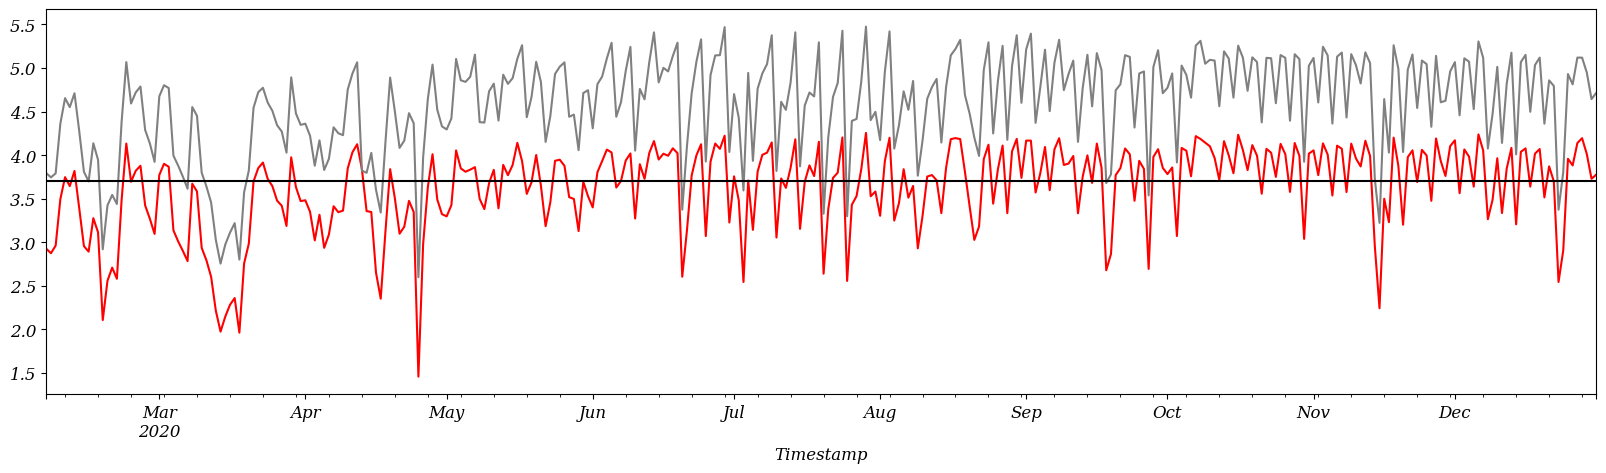

In [9]:
tst['NIVEL DO RESERVATÓRIO - LT01'].plot(color = 'r', figsize = (20,5))
tst['PRESSÃO DE SUCÇÃO - PT01'].plot(color = 'gray')
plt.axhline(y=3.7, color = 'black')
plt.show()

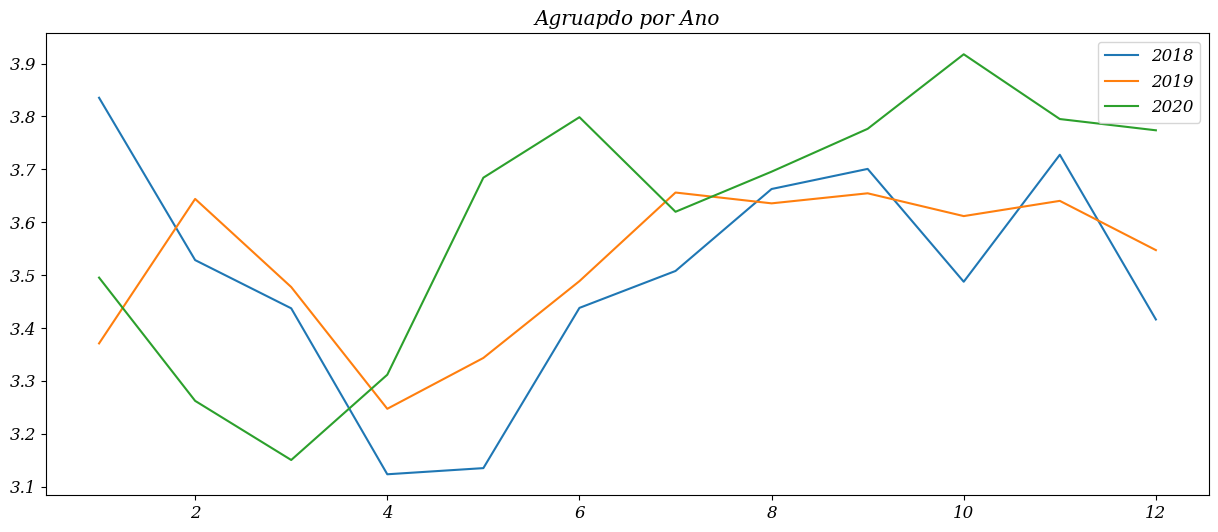

In [10]:

## Agrupando por ano
idx_year = df.index.year
idx_month = df.index.month
plt.figure(figsize = (15,6))
plt.plot(endog.groupby(by = [idx_year, idx_month]).mean().unstack(level = 0))
plt.title('Agruapdo por Ano')
plt.legend(['2018','2019', '2020'])
plt.savefig(f"media-agrupada.png", dpi=300)
plt.show()

## Diferença com o valor anterior

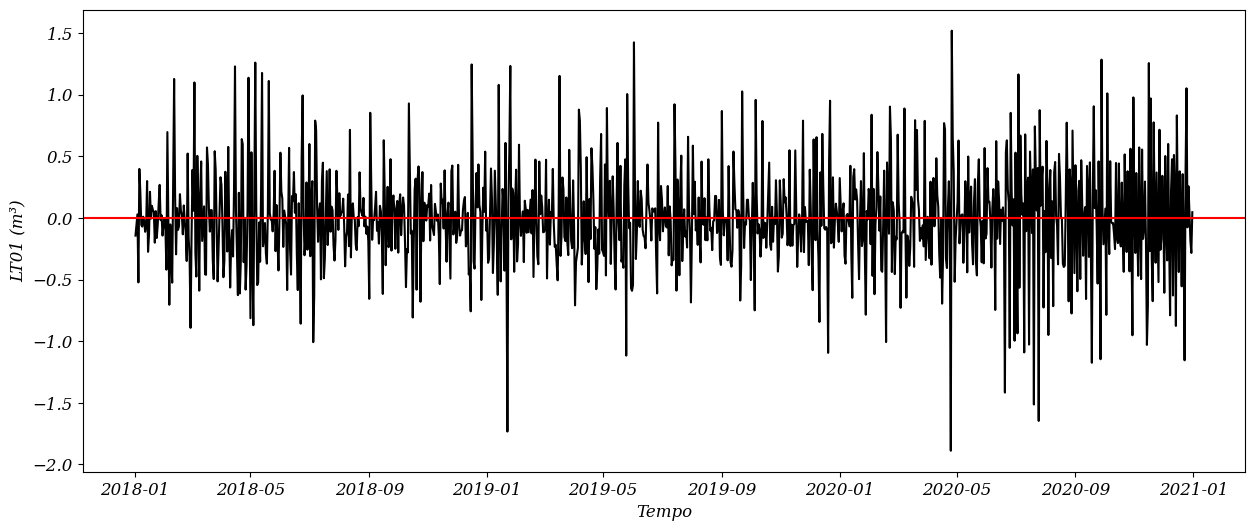

In [11]:

plt.figure(figsize = (15,6))

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog.diff(), color = 'black')
plt.axhline(y=0, color = 'r')
plt.ylabel(rt)
plt.xlabel("Tempo")
plt.savefig("estacionaridade.png", dpi=300)
plt.show()

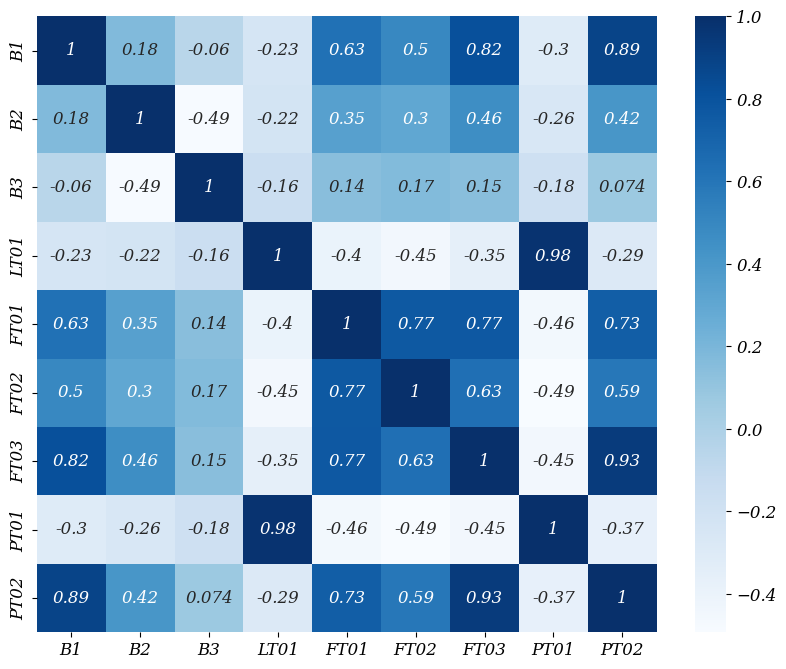

In [12]:
df2 = df.rename(columns={'FREQUENCIA BOMBA 1': 'B1',
                        'FREQUENCIA BOMBA 2': 'B2',
                        'FREQUENCIA BOMBA 3': 'B3',
                        'NIVEL DO RESERVATÓRIO - LT01': 'LT01',
                        'VAZÃO DE ENTRADA- FT01': 'FT01',
                        'VAZÃO DE GRAVIDADE - FT02': 'FT02',
                        'VAZÃO DE RECALQUE - FT03': 'FT03',
                        'PRESSÃO DE SUCÇÃO - PT01': 'PT01',
                        'PRESSÃO DE RECALQUE - PT02': 'PT02'})

plt.figure(figsize = (10,8))
sns.color_palette(as_cmap = True)
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'Blues')
plt.savefig(f"person.png", dpi=300)
plt.show()

In [13]:
from pandas_profiling import ProfileReport
import sweetviz as sv

# EDA using pandas-profiling
profile = ProfileReport(df, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

# EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


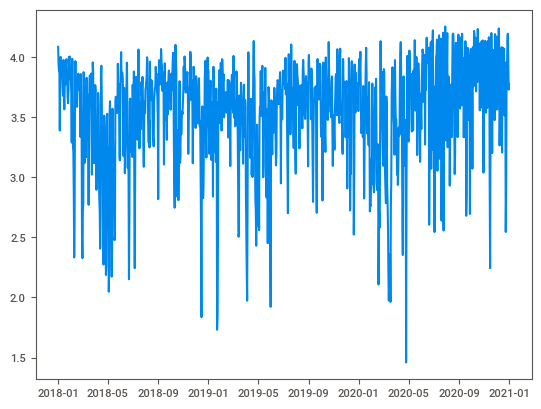

In [14]:
plt.plot(df2.LT01)

In [15]:

import dtale


dtale.show(df2)

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

s = df2['LT01']
sd_result = seasonal_decompose(s, model='additive')

In [17]:
from statsmodels.tsa.filters.hp_filter import hpfilter

s = df['NIVEL DO RESERVATÓRIO - LT01']
cycle, trend = hpfilter(s, lamb=1600)

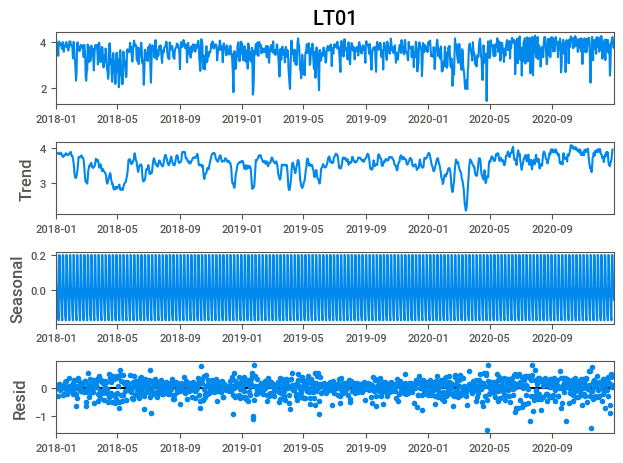

In [18]:
sd_result.plot();

# Ruido branco

In [19]:
df.mean()

FREQUENCIA BOMBA 1               48.830497
FREQUENCIA BOMBA 2               17.538055
FREQUENCIA BOMBA 3                4.298657
NIVEL DO RESERVATÓRIO - LT01      3.544512
VAZÃO DE ENTRADA- FT01          211.770616
VAZÃO DE GRAVIDADE - FT02       113.804986
VAZÃO DE RECALQUE - FT03        100.138612
PRESSÃO DE SUCÇÃO - PT01          4.485225
PRESSÃO DE RECALQUE - PT02       19.424306
dtype: float64

In [20]:
df2.mean().to_excel('media.xlsx')


In [21]:
df2.describe().to_excel('estatistica.xlsx')

In [22]:
df.describe()

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,48.830497,17.538055,4.298657,3.544512,211.770616,113.804986,100.138612,4.485225,19.424306
std,12.354038,9.281923,8.975660,0.437642,44.496078,21.485903,19.821714,0.486895,4.323327
min,0.000000,0.000000,0.000000,1.458840,22.853874,3.583976,10.383355,1.924965,0.830832
25%,50.491298,13.288937,0.000000,3.345124,195.944118,105.095669,99.238742,4.244901,19.805492
50%,54.203522,19.964554,0.000000,3.644086,215.790903,115.733042,104.845575,4.570760,21.015114
75%,54.818361,22.791507,2.375866,3.842757,238.325011,126.246380,110.005659,4.813108,21.140136
max,57.884742,53.488396,46.841334,4.255611,301.862820,181.565478,143.988415,5.475387,23.678933



# Métodos preditivos

In [23]:

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df2.LT01.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.248240
p-value: 0.000545


<Figure size 1500x600 with 0 Axes>

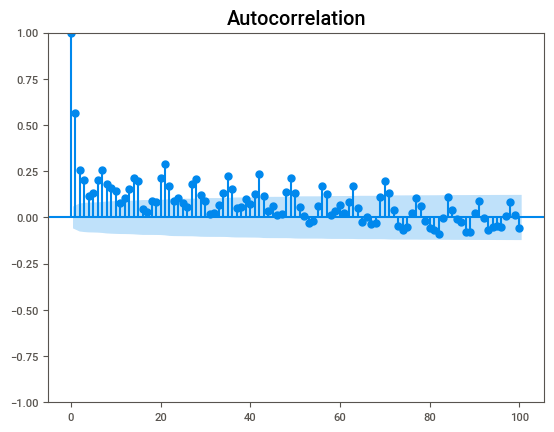

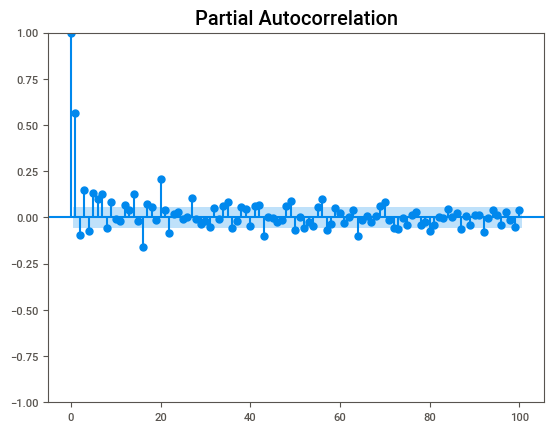

In [24]:

plt.figure(figsize = (15,6))
plot_acf(endog,lags=100)
plot_pacf(endog,lags=100)
plt.show()


## Estacionalidade


In [25]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Passa numa série cronológica e num título opcional, devolve um relatório ADF
    """
    print(f'Teste de Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['Estatística de teste ADF', 'p-valor', '# atrasos utilizados', '# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Fortes provas contra a hipótese nula")
        print("Rejeitar a hipótese nula")
        print("Os dados não têm raiz unitária e são estacionários")
    else:
        print("Fracas provas contra a hipótese nula")
        print("Não rejeitar a hipótese nula")
        print("Os dados têm uma raiz unitária e não são estacionários")


adf_test(endog)


Teste de Dickey-Fuller Aumentado: 
Estatística de teste ADF      -4.248240
p-valor                        0.000545
# atrasos utilizados          21.000000
# observações               1074.000000
valor crítico (1%)            -3.436453
valor crítico (5%)            -2.864235
valor crítico (10%)           -2.568205
Fortes provas contra a hipótese nula
Rejeitar a hipótese nula
Os dados não têm raiz unitária e são estacionários


# Decomposição STL

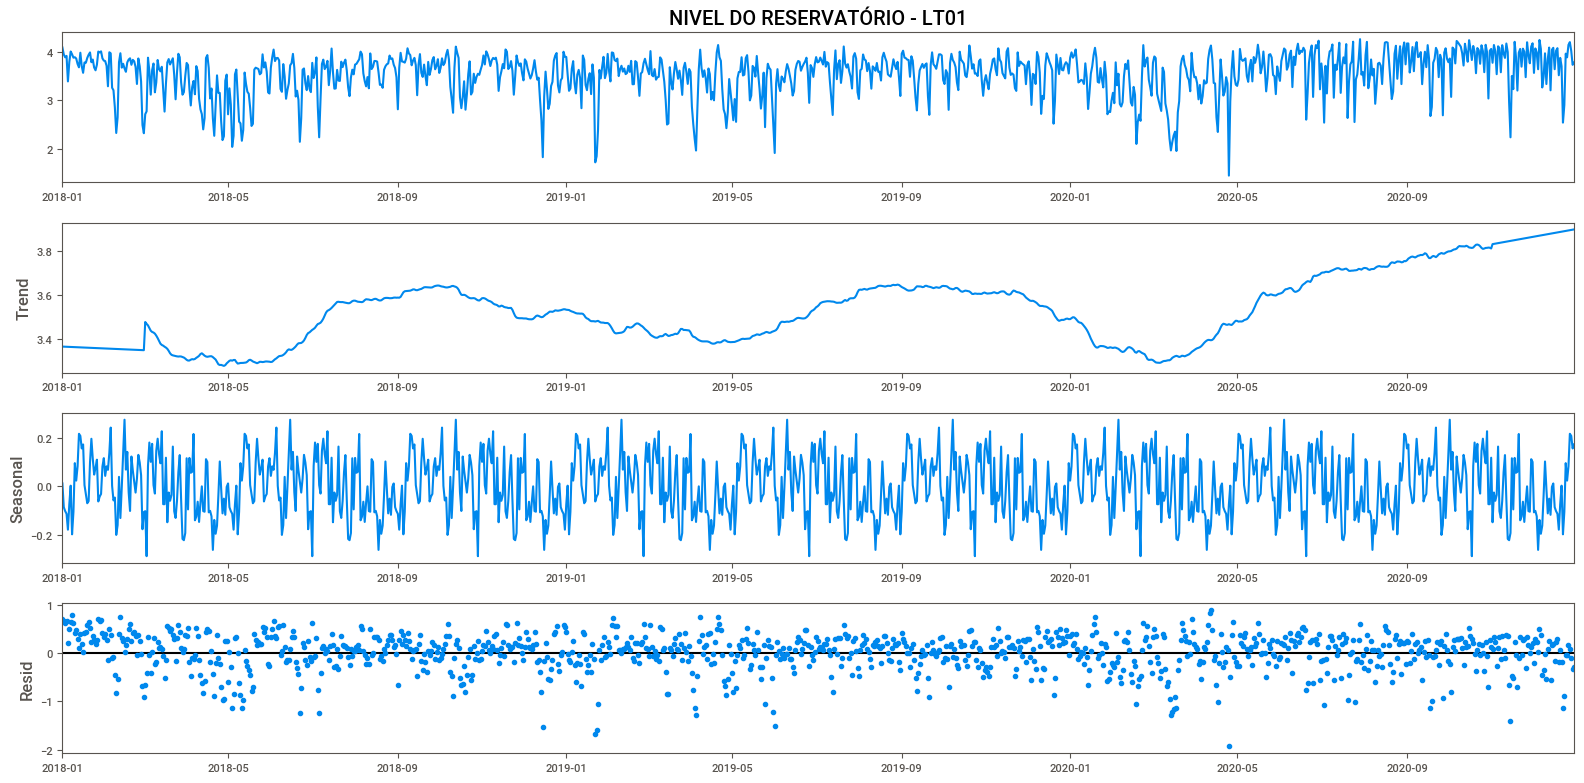

In [26]:

rst = stl(endog, model='additive', extrapolate_trend='freq', period=10*12)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.plot()
plt.show()


<Figure size 1500x600 with 0 Axes>

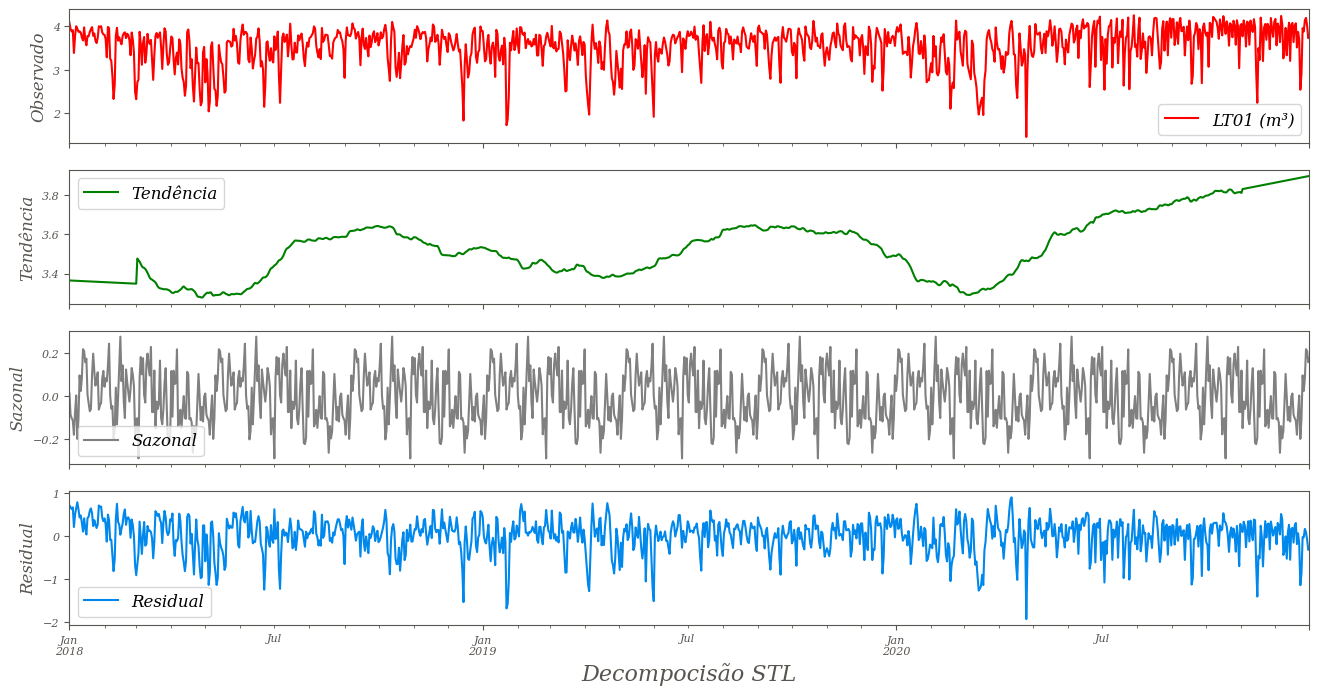

In [27]:
plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
fig, axes = plt.subplots(4, 1, sharex=True)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.observed.plot(ax=axes[0], legend=True, label = rt, color='r')
axes[0].set_ylabel('Observado')
rst.trend.plot(ax=axes[1], legend=True, label = 'Tendência', color='g')
axes[1].set_ylabel('Tendência')
rst.seasonal.plot(ax=axes[2], legend=True, label = 'Sazonal', color = 'gray')
axes[2].set_ylabel('Sazonal')
rst.resid.plot(ax=axes[3], legend=True, label = 'Residual')
axes[3].set_ylabel('Residual')
plt.xlabel( 'Decompocisão STL', fontsize = 16)
plt.savefig("STL.png", dpi=300)
plt.show()


In [28]:


from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(endog)


(0.01, False)

In [29]:
# ## Auto ARIMA 
# from pmdarima import auto_arima
# stepwise_fit = auto_arima(endog, start_p=0, start_q=0,
#                           max_p=7, max_q=7, m=12,
#                           start_P=0, seasonal=True,
#                           d=1, D=1, trace=True,
#                           error_action='ignore',   # não queremos saber se uma encomenda não funciona
#                           suppress_warnings=True,  # não queremos avisos de convergência
#                           stepwise=True)           # programado para escalonar
# stepwise_fit.summary()


## Modelo atualizado

In [30]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]+arima[22]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [31]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [32]:
# best = pd.read_excel("best.xlsx")
# p1 = int(best['p'])
# d1 = int(best['d'])
# q1 = int(best['q'])
# P1 = int(best['P'])
# D1 = int(best['D'])
# Q1 = int(best['Q'])
# M1 = int(best['M'])

In [33]:
p1 = 7
d1 = 1
q1 = 7
P1 = 2
D1 = 1
Q1 = 1
M1 = 12

# Modelos de previsão


## Numeros de dias


In [34]:
# # Sem as 24 horas
# pv = 7*24
# pvl = str(int(pv/24))+' dias a frente'

# print(pv, pvl)

# Com as 24 horas
pv = 0
pvl = str(pv)+' dia a frente'

print(pv, pvl)

0 0 dia a frente


## Auto-Regressivo Exogedo (ARX)

In [35]:
model_trn = ARIMA(endog_trn, exog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, exog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, exog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, exog, order = (p1,0,0))
res = model.fit()

### Previsão

arx_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arx_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arx_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arx = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])

### Erros AR

mape_ARX_trn = mean_absolute_percentage_error(endog_trn, arx_trn[pv+1:])*100
mape_ARX_vld = mean_absolute_percentage_error(endog_vld, arx_vld[pv+1:])*100
mape_ARX_tst = mean_absolute_percentage_error(endog_tst, arx_tst[pv+1:])*100
ARX_mape = mean_absolute_percentage_error(endog, arx[pv+1:])*100

mae_ARX_trn = mean_absolute_error(endog_trn, arx_trn[pv+1:])*100
mae_ARX_vld = mean_absolute_error(endog_vld, arx_vld[pv+1:])*100
mae_ARX_tst = mean_absolute_error(endog_tst, arx_tst[pv+1:])*100
ARX_mae = mean_absolute_error(endog, arx[pv+1:])*100

rmse_ARX_trn = mean_squared_error(endog_trn, arx_trn[pv+1:], squared = False)*100
rmse_ARX_vld = mean_squared_error(endog_vld, arx_vld[pv+1:], squared = False)*100
rmse_ARX_tst = mean_squared_error(endog_tst, arx_tst[pv+1:], squared = False)*100
ARX_rmse = mean_squared_error(endog, arx[pv+1:])*100


print(f"ARX ({p1}) MAPE Error: {mape_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAPE Error: {mape_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAPE Error: {ARX_mape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_mae:2.3f} ")

print(f"ARX ({p1}) RMSE Error: {rmse_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) RMSE Error: {rmse_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) RMSE Error: {ARX_rmse:2.3f} ")

### Plotagem das previsão



# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(arx_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( pvl + ' Auto-Regressivo Exogedo', fontsize = 16)
# plt.legend(['Observado', f"ARX ({p1})"])
# plt.savefig(pvl+"  ARX TEST.png", dpi=300)
# plt.show()


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARX (7) MAPE Error: 8.195 Train
ARX (7) MAPE Error: 7.400 Validation
ARX (7) MAPE Error: 10.778 Test
ARX (7) MAPE Error: 8.916 
ARX (7) MAE Error: 26.357 Train
ARX (7) MAE Error: 25.252 Validation
ARX (7) MAE Error: 36.708 Test
ARX (7) MAE Error: 29.498 
ARX (7) RMSE Error: 36.719 Train
ARX (7) RMSE Error: 34.529 Validation
ARX (7) RMSE Error: 48.597 Test
ARX (7) RMSE Error: 16.662 


# Lag Ljung Box

In [36]:
lag = [10]
lag

[10]

In [37]:

lj_arx_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arx_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arx_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arx_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## Auto-Regressivo (AR)


In [38]:
model_trn = ARIMA(endog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, order = (p1,0,0))
res = model.fit()

### Previsão

ar_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ar_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ar_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
ar = res.predict(start = -len(df), end = len(df)+pv)

### Erros AR

mape_AR_trn = mean_absolute_percentage_error(endog_trn, ar_trn[pv+1:])*100
mape_AR_vld = mean_absolute_percentage_error(endog_vld, ar_vld[pv+1:])*100
mape_AR_tst = mean_absolute_percentage_error(endog_tst, ar_tst[pv+1:])*100
AR_mape = mean_absolute_percentage_error(endog, ar[pv+1:])*100

mae_AR_trn = mean_absolute_error(endog_trn, ar_trn[pv+1:])*100
mae_AR_vld = mean_absolute_error(endog_vld, ar_vld[pv+1:])*100
mae_AR_tst = mean_absolute_error(endog_tst, ar_tst[pv+1:])*100
AR_mae = mean_absolute_error(endog, ar[pv+1:])*100

rmse_AR_trn = mean_squared_error(endog_trn, ar_trn[pv+1:], squared = False)*100
rmse_AR_vld = mean_squared_error(endog_vld, ar_vld[pv+1:], squared = False)*100
rmse_AR_tst = mean_squared_error(endog_tst, ar_tst[pv+1:], squared = False)*100
AR_rmse = mean_squared_error(endog, ar[pv+1:])*100

print(f"AR ({p1}) MAPE Error: {mape_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAPE Error: {mape_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAPE Error: {mape_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAPE Error: {AR_mape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_mae:2.3f} ")

print(f"AR ({p1}) RMSE Error: {rmse_AR_trn:2.3f} Train")
print(f"AR ({p1}) RMSE Error: {rmse_AR_vld:2.3f} Validation")
print(f"AR ({p1}) RMSE Error: {rmse_AR_tst:2.3f} Test")
print(f"AR ({p1}) RMSE Error: {AR_rmse:2.3f} ")

### Plotagem das previsão



# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(ar_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( pvl + ' Auto-Regressivo', fontsize = 16)
# plt.legend(['Observado', f"AR ({p1})"])
# plt.savefig(pvl+"  AR TEST.png", dpi=300)
# plt.show()


AR (7) MAPE Error: 4.922 Train
AR (7) MAPE Error: 4.746 Validation
AR (7) MAPE Error: 6.772 Test
AR (7) MAPE Error: 5.087 
AR (7) MAE Error: 15.676 Train
AR (7) MAE Error: 16.071 Validation
AR (7) MAE Error: 22.369 Test
AR (7) MAE Error: 16.360 
AR (7) RMSE Error: 20.532 Train
AR (7) RMSE Error: 20.379 Validation
AR (7) RMSE Error: 27.418 Test
AR (7) RMSE Error: 4.610 


In [39]:
lj_ar_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ar_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ar_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ar_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Médias Móveis (MA)


In [40]:

model_trn = ARIMA(endog_trn,order=(0,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(0,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(0,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(0,0,1))
res = model.fit()

### Previsão

ma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
MA = res.predict(start = -len(df), end = len(df)+pv)

### Erros MA

mape_MA_trn = mean_absolute_percentage_error(endog_trn, ma_trn[pv+1:])*100
mape_MA_vld = mean_absolute_percentage_error(endog_vld, ma_vld[pv+1:])*100
mape_MA_tst = mean_absolute_percentage_error(endog_tst, ma_tst[pv+1:])*100
MA_mape = mean_absolute_percentage_error(endog, MA[pv+1:])*100

mae_MA_trn = mean_absolute_error(endog_trn, ma_trn[pv+1:])*100
mae_MA_vld = mean_absolute_error(endog_vld, ma_vld[pv+1:])*100
mae_MA_tst = mean_absolute_error(endog_tst, ma_tst[pv+1:])*100
MA_mae = mean_absolute_error(endog, MA[pv+1:])*100

rmse_MA_trn = mean_squared_error(endog_trn, ma_trn[pv+1:], squared = False)*100
rmse_MA_vld = mean_squared_error(endog_vld, ma_vld[pv+1:], squared = False)*100
rmse_MA_tst = mean_squared_error(endog_tst, ma_tst[pv+1:], squared = False)*100
MA_rmse = mean_squared_error(endog, MA[pv+1:], squared = False)*100

print(f"MA ({q1}) MAPE Error: {mape_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAPE Error: {mape_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAPE Error: {mape_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAPE Error: {MA_mape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_mae:2.3f} ")

print(f"MA ({q1}) RMSE Error: {rmse_MA_trn:2.3f} Train")
print(f"MA ({q1}) RMSE Error: {rmse_MA_vld:2.3f} Validation")
print(f"MA ({q1}) RMSE Error: {rmse_MA_tst:2.3f} Test")
print(f"MA ({q1}) RMSE Error: {MA_rmse:2.3f} Test")


### Plotagem das previsão


# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(ma_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(pvl+' Médias Móveis', fontsize = 16)
# plt.legend(['Observedo', f"MA ({q1})"])
# plt.savefig(pvl+" MA TEST.png", dpi=300)

# plt.show()


MA (7) MAPE Error: 4.554 Train
MA (7) MAPE Error: 4.584 Validation
MA (7) MAPE Error: 6.941 Test
MA (7) MAPE Error: 6.375 
MA (7) MAE Error: 14.419 Train
MA (7) MAE Error: 15.529 Validation
MA (7) MAE Error: 23.018 Test
MA (7) MAE Error: 20.525 
MA (7) RMSE Error: 19.061 Train
MA (7) RMSE Error: 19.905 Validation
MA (7) RMSE Error: 28.115 Test
MA (7) RMSE Error: 27.034 Test


In [41]:

lj_ma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## ARMA


In [42]:

model_trn = ARIMA(endog_trn,order=(p1,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(p1,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(p1,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(p1,0,q1))
res = model.fit()

arma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arma = res.predict(start = -len(df), end = len(df)+pv)


### Erros ARMA



mape_ARMA_trn = mean_absolute_percentage_error(endog_trn, arma_trn[pv+1:])*100
mape_ARMA_vld = mean_absolute_percentage_error(endog_vld, arma_vld[pv+1:])*100
mape_ARMA_tst = mean_absolute_percentage_error(endog_tst, arma_tst[pv+1:])*100
ARMA_mape = mean_absolute_percentage_error(endog, arma[pv+1:])*100

mae_ARMA_trn = mean_absolute_error(endog_trn, arma_trn[pv+1:])*100
mae_ARMA_vld = mean_absolute_error(endog_vld, arma_vld[pv+1:])*100
mae_ARMA_tst = mean_absolute_error(endog_tst, arma_tst[pv+1:])*100
ARMA_mae = mean_absolute_error(endog, arma[pv+1:])*100

rmse_ARMA_trn = mean_squared_error(endog_trn, arma_trn[pv+1:], squared = False)*100
rmse_ARMA_vld = mean_squared_error(endog_vld, arma_vld[pv+1:], squared = False)*100
rmse_ARMA_tst = mean_squared_error(endog_tst, arma_tst[pv+1:], squared = False)*100
ARMA_rmse = mean_squared_error(endog, arma[pv+1:], squared = False)*100


print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAPE Error: {mape_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAPE Error: {ARMA_mape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_mae:2.3f}")

print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RMSE Error: {rmse_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} RMSE Error: {ARMA_rmse:2.3f} Test")

### Plotagem das previsão


# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(arma_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(pvl+' ARMA', fontsize = 16)
# plt.legend(['Observedo', f"ARMA {p1,q1}"])
# plt.savefig(pvl+" ARMA TEST.png", dpi=300)
# plt.show()


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARMA (7, 7) MAPE Error: 5.455 Train
ARMA (7, 7) MAPE Error: 5.456 Validation
ARMA (7, 7) MAPE Error: 7.308 Test
ARMA (7, 7) MAPE Error: 5.395 
ARMA (7, 7) MAE Error: 17.649 Train
ARMA (7, 7) MAE Error: 18.806 Validation
ARMA (7, 7) MAE Error: 24.829 Test
ARMA (7, 7) MAE Error: 17.490
ARMA (7, 7) RMSE Error: 22.787 Train
ARMA (7, 7) RMSE Error: 22.954 Validation
ARMA (7, 7) RMSE Error: 29.749 Test
ARMA (7, 7) RMSE Error: 23.053 Test


In [43]:

lj_arma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMA

In [44]:

model_trn = ARIMA(endog_trn,
                        order=(p1,d1,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,
                        order=(p1,d1,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,
                        order=(p1,d1,q1))
res_tst = model_tst.fit()

model_df = ARIMA(endog,
                        order=(p1,d1,q1))
res_df = model_df.fit()

arima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arima = res_df.predict(start = -len(df), end = len(df)+pv)

### Erros ARIMA



mape_ARIMA_trn = mean_absolute_percentage_error(endog_trn, arima_trn[pv+1:])*100
mape_ARIMA_vld = mean_absolute_percentage_error(endog_vld, arima_vld[pv+1:])*100
mape_ARIMA_tst = mean_absolute_percentage_error(endog_tst, arima_tst[pv+1:])*100
ARIMA_mape = mean_absolute_percentage_error(endog, arima[pv+1:])*100

mae_ARIMA_trn = mean_absolute_error(endog_trn, arima_trn[pv+1:])*100
mae_ARIMA_vld = mean_absolute_error(endog_vld, arima_vld[pv+1:])*100
mae_ARIMA_tst = mean_absolute_error(endog_tst, arima_tst[pv+1:])*100
ARIMA_mae = mean_absolute_error(endog, arima[pv+1:])*100

rmse_ARIMA_trn = mean_squared_error(endog_trn, arima_trn[pv+1:], squared = False)*100
rmse_ARIMA_vld = mean_squared_error(endog_vld, arima_vld[pv+1:], squared = False)*100
rmse_ARIMA_tst = mean_squared_error(endog_tst, arima_tst[pv+1:], squared = False)*100
ARIMA_rmse = mean_squared_error(endog, arima[pv+1:], squared = False)*100

print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAPE Error: {mape_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAPE Error: {ARIMA_mape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RMSE Error: {rmse_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RMSE Error: {ARIMA_rmse:2.3f}")


### Plotagem das previsão

# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(arima_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(pvl+' ARIMA', fontsize = 16)
# plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
# plt.savefig(pvl+" ARIMA TEST.png", dpi=300)
# plt.show()


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (7, 1, 7) MAPE Error: 5.171 Train
ARIMA (7, 1, 7) MAPE Error: 4.827 Validation
ARIMA (7, 1, 7) MAPE Error: 7.331 Test
ARIMA (7, 1, 7) MAPE Error: 5.326
ARIMA (7, 1, 7) MAE Error: 16.556 Train
ARIMA (7, 1, 7) MAE Error: 16.288 Validation
ARIMA (7, 1, 7) MAE Error: 25.003 Test
ARIMA (7, 1, 7) MAE Error: 17.198
ARIMA (7, 1, 7) RMSE Error: 22.003 Train
ARIMA (7, 1, 7) RMSE Error: 20.820 Validation
ARIMA (7, 1, 7) RMSE Error: 30.465 Test
ARIMA (7, 1, 7) RMSE Error: 22.561


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [45]:

lj_arima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMA


In [46]:
model_trn = sr(endog_trn,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_trn = model_trn.fit(dis=False)

model_vld = sr(endog_vld,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_vld = model_vld.fit(dis=False)

model_tst = sr(endog_tst,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_tst = model_tst.fit(dis=False)

model_df = sr(endog,order=(p1,d1,q1),
                seasonal_order = (P1,D1,Q1,M1),
                simple_differencing=False)
res_df = model_df.fit(dis=False)

### Erro SARIMA

sarima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
sarima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
sarima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
sarima = res_df.predict(start = -len(df), end = len(df)+pv)

mape_SARIMA_trn = mean_absolute_percentage_error(endog_trn, sarima_trn[pv+1:])*100
mape_SARIMA_vld = mean_absolute_percentage_error(endog_vld, sarima_vld[pv+1:])*100
mape_SARIMA_tst = mean_absolute_percentage_error(endog_tst, sarima_tst[pv+1:])*100
SARIMA_mape = mean_absolute_percentage_error(endog, sarima[pv+1:])*100

mae_SARIMA_trn = mean_absolute_error(endog_trn, sarima_trn[pv+1:])*100
mae_SARIMA_vld = mean_absolute_error(endog_vld, sarima_vld[pv+1:])*100
mae_SARIMA_tst = mean_absolute_error(endog_tst, sarima_tst[pv+1:])*100
SARIMA_mae = mean_absolute_error(endog, sarima[pv+1:])*100

rmse_SARIMA_trn = mean_squared_error(endog_trn, sarima_trn[pv+1:], squared = False)*100
rmse_SARIMA_vld = mean_squared_error(endog_vld, sarima_vld[pv+1:], squared = False)*100
rmse_SARIMA_tst = mean_squared_error(endog_tst, sarima_tst[pv+1:], squared = False)*100
SARIMA_rmse = mean_squared_error(endog, sarima[pv+1:], squared = False)*100

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {mape_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAPE Error: {SARIMA_mape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {rmse_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RMSE Error: {SARIMA_rmse:2.3f}")

### Plotagem da previsão

# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color = 'black')
# plt.plot(sarima_tst, color = 'red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(pvl+' SARIMA', fontsize = 16)
# plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
# plt.savefig(pvl+" SARIMA TEST.png", dpi=300)
# plt.show()


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA (7, 1, 7) (2, 1, 1, 12) MAPE Error: 5.527 Train
SARIMA (7, 1, 7) (2, 1, 1, 12) MAPE Error: 5.639 Validation
SARIMA (7, 1, 7) (2, 1, 1, 12) MAPE Error: 7.883 Test
SARIMA (7, 1, 7) (2, 1, 1, 12) MAPE Error: 5.830
SARIMA (7, 1, 7) (2, 1, 1, 12) MAE Error: 18.143 Train
SARIMA (7, 1, 7) (2, 1, 1, 12) MAE Error: 19.573 Validation
SARIMA (7, 1, 7) (2, 1, 1, 12) MAE Error: 26.698 Test
SARIMA (7, 1, 7) (2, 1, 1, 12) MAE Error: 19.215
SARIMA (7, 1, 7) (2, 1, 1, 12) RMSE Error: 24.243 Train
SARIMA (7, 1, 7) (2, 1, 1, 12) RMSE Error: 28.857 Validation
SARIMA (7, 1, 7) (2, 1, 1, 12) RMSE Error: 34.785 Test
SARIMA (7, 1, 7) (2, 1, 1, 12) RMSE Error: 24.838


ADF Statistic: -4.26788425740548
p-value: 0.0005046682956432282


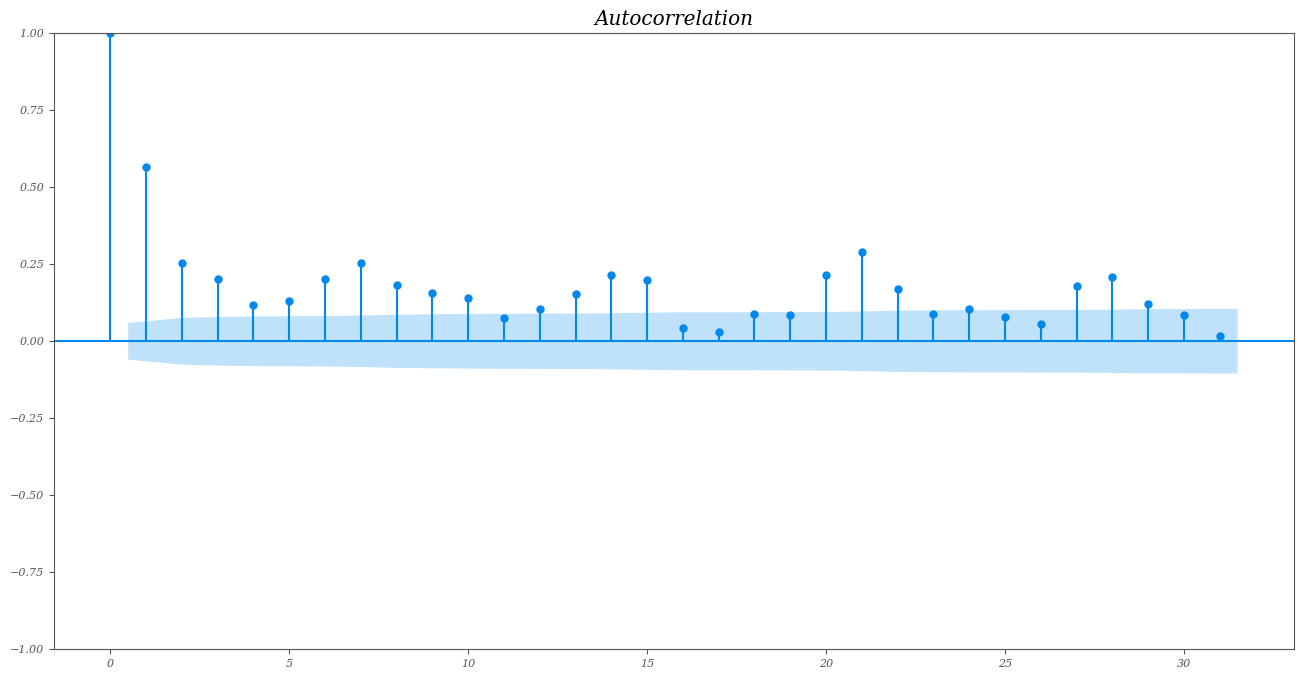

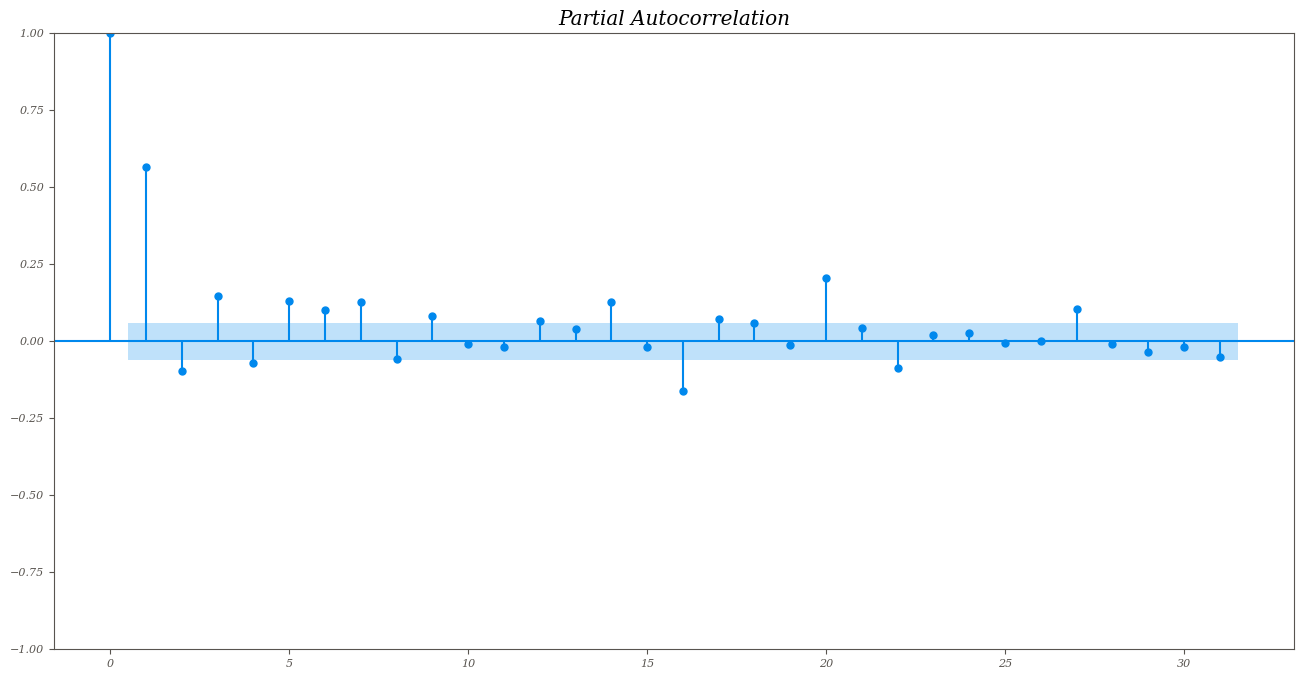

In [47]:

ad_fuller_result = adfuller(endog[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


plot_acf(endog[1:]);
plot_pacf(endog[1:]);


In [48]:

lj_sarima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMAX

In [49]:

best_model_tst = ARIMA(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1))


res_tst = best_model_tst.fit()
### Validação



best_model_vld = ARIMA(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1))

res_vld = best_model_vld.fit()

### Treino

best_model_trn = ARIMA(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1))

res_trn = best_model_trn.fit()

### ARIMAX

best_model = ARIMA(endog, 
                     exog, 
                     order=(p1,d1,q1))

res = best_model.fit()



### Prevendo ARIMAX

arimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros ARIMAX

mape_arimax_trn = mean_absolute_percentage_error(endog_trn, arimax_trn[pv+1:])*100
mape_arimax_vld = mean_absolute_percentage_error(endog_vld, arimax_vld[pv+1:])*100
mape_arimax_tst = mean_absolute_percentage_error(endog_tst, arimax_tst[pv+1:])*100
arimax_mape = mean_absolute_percentage_error(endog, arimax[pv+1:])*100

mae_arimax_trn = mean_absolute_error(endog_trn, arimax_trn[pv+1:])*100
mae_arimax_vld = mean_absolute_error(endog_vld, arimax_vld[pv+1:])*100
mae_arimax_tst = mean_absolute_error(endog_tst, arimax_tst[pv+1:])*100
arimax_mae = mean_absolute_error(endog, arimax[pv+1:])*100

rmse_arimax_trn = mean_squared_error(endog_trn, arimax_trn[pv+1:], squared = False)*100
rmse_arimax_vld = mean_squared_error(endog_vld, arimax_vld[pv+1:], squared = False)*100
rmse_arimax_tst = mean_squared_error(endog_tst, arimax_tst[pv+1:], squared = False)*100
arimax_rmse = mean_squared_error(endog, arimax[pv+1:], squared = False)*100

print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAPE Error: {mape_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAPE Error: {arimax_mape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} MAE Error: {arimax_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RMSE Error: {rmse_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1} RMSE Error: {arimax_rmse:2.3f}")

# Visualiza previsão
# # test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color ='black')
# plt.plot(arimax_tst, color ='red')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(pvl+f' ARIMAX {p1,d1,q1}', fontsize = 16)
# plt.legend(['Observado','Previsto'])
# plt.savefig(pvl+" ARIMAX TEST.png", dpi=300)
# plt.show()

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMAX (7, 1, 7)  MAPE Error: 8.235 Train
ARIMAX (7, 1, 7)  MAPE Error: 7.381 Validation
ARIMAX (7, 1, 7)  MAPE Error: 10.782 Test
ARIMAX (7, 1, 7) MAPE Error: 8.743
ARIMAX (7, 1, 7)  MAE Error: 26.480 Train
ARIMAX (7, 1, 7)  MAE Error: 25.185 Validation
ARIMAX (7, 1, 7)  MAE Error: 36.705 Test
ARIMAX (7, 1, 7) MAE Error: 28.917
ARIMAX (7, 1, 7)  RMSE Error: 36.548 Train
ARIMAX (7, 1, 7)  RMSE Error: 34.435 Validation
ARIMAX (7, 1, 7)  RMSE Error: 48.713 Test
ARIMAX (7, 1, 7) RMSE Error: 39.983


In [50]:

lj_arimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMAX

In [51]:

best_model_tst = sr(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)


res_tst = best_model_tst.fit(dis=False)
### Validação



best_model_vld = sr(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_vld = best_model_vld.fit(dis=False)

### Treino

best_model_trn = sr(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_trn = best_model_trn.fit(dis=False)

### DADOS COMPLETO

best_model = sr(endog, 
                     exog, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res = best_model.fit(dis=False)

### Prevendo SARIMAX

sarimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])

sarimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])

sarimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])

sarimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros SARIMAX

mape_sarimax_trn = mean_absolute_percentage_error(endog_trn, sarimax_trn[pv+1:])*100
mape_sarimax_vld = mean_absolute_percentage_error(endog_vld, sarimax_vld[pv+1:])*100
mape_sarimax_tst = mean_absolute_percentage_error(endog_tst, sarimax_tst[pv+1:])*100
sarimax_mape = mean_absolute_percentage_error(endog, sarimax[pv+1:])*100

mae_sarimax_trn = mean_absolute_error(endog_trn, sarimax_trn[pv+1:])*100
mae_sarimax_vld = mean_absolute_error(endog_vld, sarimax_vld[pv+1:])*100
mae_sarimax_tst = mean_absolute_error(endog_tst, sarimax_tst[pv+1:])*100
sarimax_mae = mean_absolute_error(endog, sarimax[pv+1:])*100

rmse_sarimax_trn = mean_squared_error(endog_trn, sarimax_trn[pv+1:], squared = False)*100
rmse_sarimax_vld = mean_squared_error(endog_vld, sarimax_vld[pv+1:], squared = False)*100
rmse_sarimax_tst = mean_squared_error(endog_tst, sarimax_tst[pv+1:], squared = False)*100
sarimax_rmse = mean_squared_error(endog, sarimax[pv+1:], squared = False)*100


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAPE Erro: {mape_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAPE Erro: {sarimax_mape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RMSE Erro: {rmse_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RMSE Erro: {sarimax_rmse:2.3f}")


# Visualiza previsão

# test
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, color ='black')
# plt.plot(sarimax_tst, color ='red')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+f' SARIMAX ', fontsize = 16)
# plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(pvl+" SARIMAX TEST.png", dpi=300)
# plt.show()

In [ ]:

lj_sarimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Comparação dos modelos ARIMA

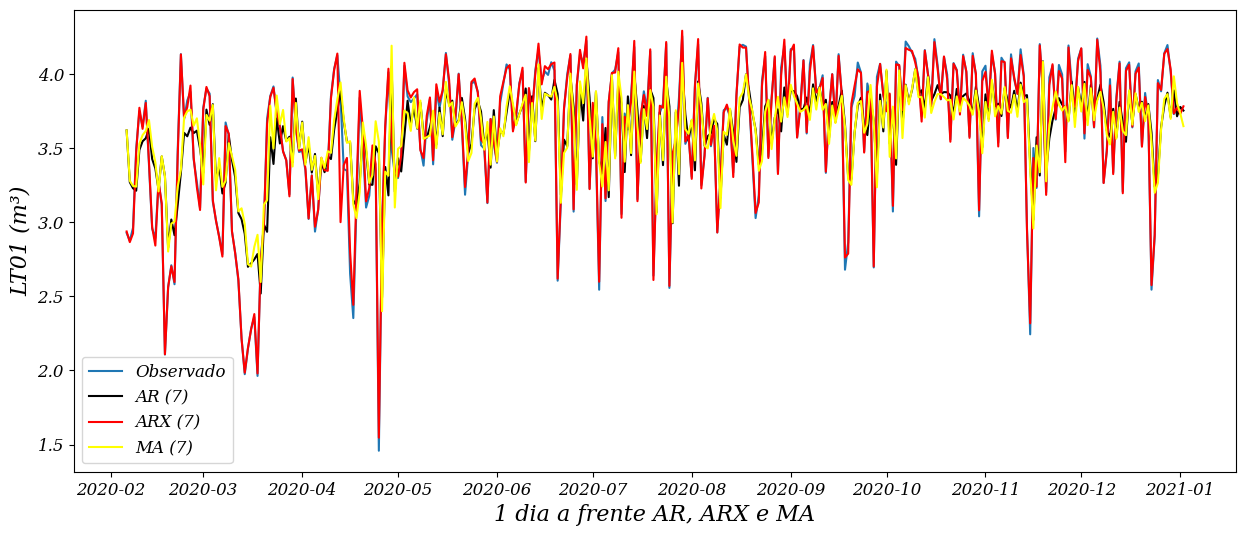

In [ ]:
plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst)
plt.plot(ar_tst, 'black')
plt.plot(arx_tst, 'red')
plt.plot(ma_tst, 'yellow')


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv}-AR-ARX-MA.png", dpi=300)
plt.show()

In [ ]:
# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(ar_tst), 'black')
# plt.plot(list(arx_tst), 'red')
# plt.plot(list(ma_tst), 'yellow')


# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
# plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA {q1}'])
# plt.savefig(f"{pv}-AR-ARX-MA.png", dpi=300)
# plt.show()

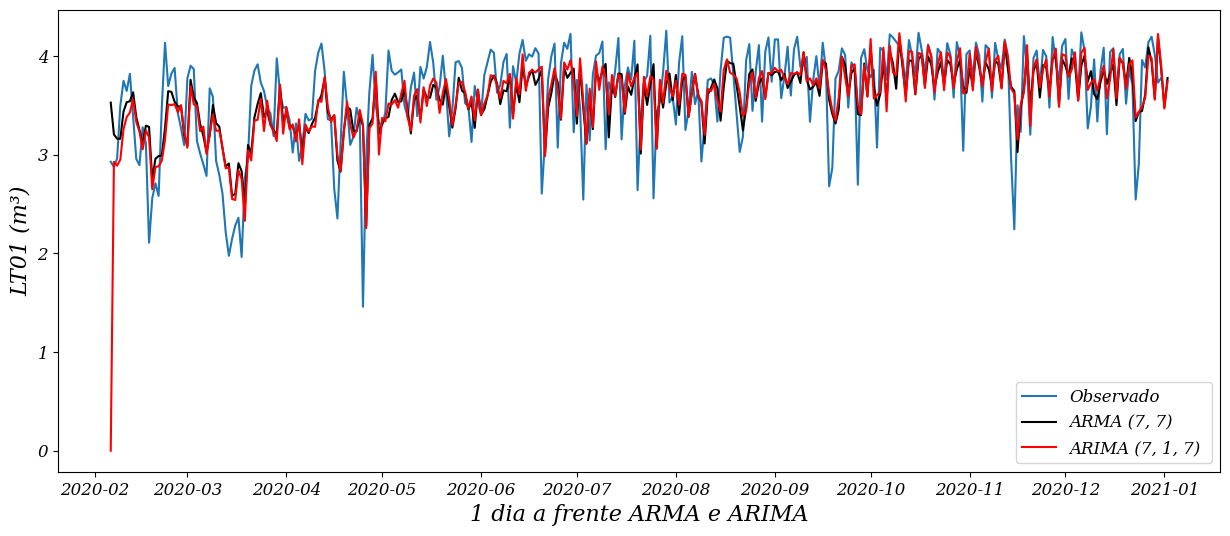

In [ ]:


plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst)
plt.plot(arma_tst, 'black')
plt.plot(arima_tst, 'red')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv}-ARMA-ARIMA.png", dpi=300)
plt.show()


In [ ]:


# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(arma_tst), 'black')
# plt.plot(list(arima_tst), 'red')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+'ARMA e ARIMA', fontsize = 16)
# plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
# plt.savefig(f"{pv}-ARMA-ARIMA.png", dpi=300)
# plt.show()


In [ ]:

# plt.figure(figsize = (15,6))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(list(endog_tst))
# plt.plot(list(sarima_tst), 'black')
# plt.plot(list(sarimax_tst), 'red')
# plt.plot(list(arimax_tst), 'yellow')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
# f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.png", dpi=300)
# plt.show()

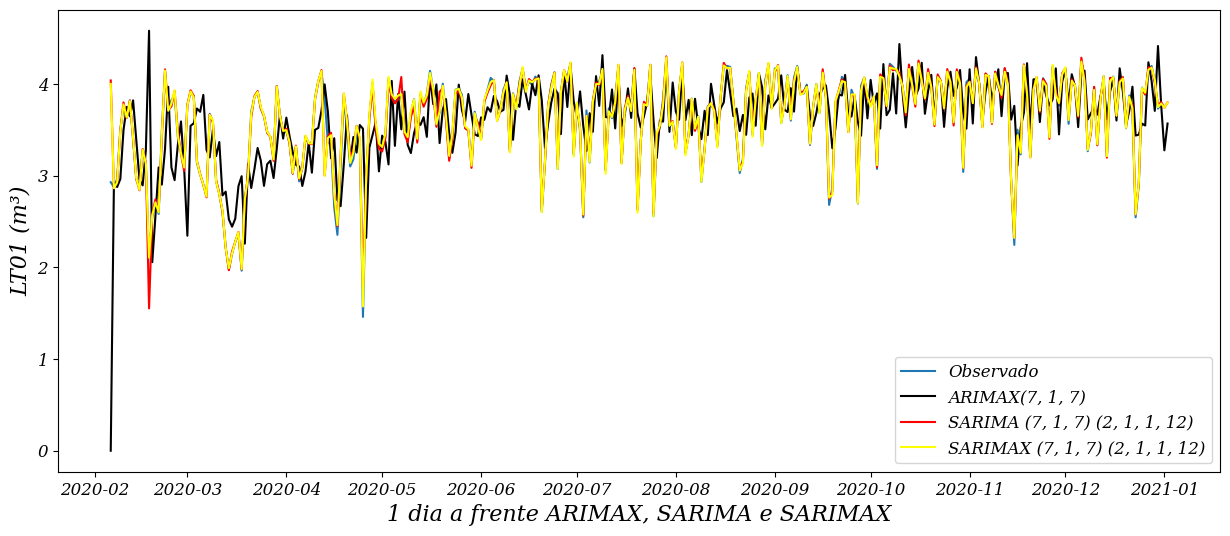

In [ ]:

plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst)
plt.plot(sarima_tst, 'black')
plt.plot(sarimax_tst, 'red')
plt.plot(arimax_tst, 'yellow')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.png", dpi=300)
plt.show()

## Regressão

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn+pv)
lr_vld = lm_vld.predict(endog_l_vld+pv)
lr_tst = lm_tst.predict(endog_l_tst+pv)
lr = lm_tst.predict(endog_l+pv)

random.seed(0)

my_xgb = XGBRegressor()

# my_xgb = BayesSearchCV(
#     XGBRegressor(),{
#         'learning_rate': (10e-6, 1.0, 'log-uniform'),
#         'max_depth': Integer(0, 50, 'uniform'),
#         'n_estimators' : (10, 1000, 'log-uniform'),},
#         n_iter=10, cv=3)
x_trn = my_xgb.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb.fit(X = exog_vld, y = endog_vld)
x = my_xgb.fit(X = exog, y = endog)
xgb_trn = x_trn.predict(exog_trn+pv)
xgb_vld = x_vld.predict(exog_vld+pv)
xgb_tst = x_tst.predict(exog_tst+pv)
xgb = x.predict(exog+pv)


my_lgbm = LGBMRegressor(max_depth = 2)

# my_lgbm = BayesSearchCV(LGBMRegressor(max_depth = 2),{
#             'learning_rate': (10e-6, 1.0, 'log-uniform'),
#             'max_depth': Integer(-1, 50, 'uniform'),
#             'n_estimators' : (10, 1000, 'log-uniform'),},
#             n_iter=10,cv=3)
lb_trn = my_lgbm.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm.fit(X = exog, y = endog)
lgbm_trn = lb_trn.predict(exog_trn+pv)
lgbm_vld = lb_vld.predict(exog_vld+pv)
lgbm_tst = lb_tst.predict(exog_tst+pv)
lgbm = lb.predict(exog+pv)

# my_rf = GridSearchCV(RandomForestRegressor(),{
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005)),
# 'n_estimators': stats.randint(50, 1000)}

# my_rf = RandomizedSearchCV(RandomForestRegressor(),
# distributions, n_iter=10,scoring = 'r2',
#     n_jobs = -1, random_state = 12345)

my_rf = RandomForestRegressor()

trn_rf = my_rf.fit(X = exog_trn, y = endog_trn)
tst_rf = my_rf.fit(X = exog_tst, y = endog_tst)
vld_rf = my_rf.fit(X = exog_vld, y = endog_vld)
rf = my_rf.fit(X = exog, y = endog)
rf_trn = trn_rf.predict(exog_trn+pv)
rf_vld = vld_rf.predict(exog_vld+pv)
rf_tst = tst_rf.predict(exog_tst+pv)
rf_df = rf.predict(exog+pv)

### Erros LR

mape_lr_trn = mean_absolute_percentage_error(endog_l_trn, lr_trn)*100
mape_lr_vld = mean_absolute_percentage_error(endog_l_vld, lr_vld)*100
mape_lr_tst = mean_absolute_percentage_error(endog_l_tst, lr_tst)*100
mape_lr = mean_absolute_percentage_error(endog_l, lr)*100


mae_lr_trn = mean_absolute_error(endog_l_trn, lr_trn)*100
mae_lr_vld = mean_absolute_error(endog_l_vld, lr_vld)*100
mae_lr_tst = mean_absolute_error(endog_l_tst, lr_tst)*100
mae_lr = mean_absolute_error(endog_l, lr)*100

rmse_lr_trn = mean_squared_error(endog_l_trn, lr_trn, squared = False)*100
rmse_lr_vld = mean_squared_error(endog_l_vld, lr_vld, squared = False)*100
rmse_lr_tst = mean_squared_error(endog_l_tst, lr_tst, squared = False)*100
rmse_lr = mean_squared_error(endog_l, lr, squared = False)*100

### Erros xgb

mape_xgb_trn = mean_absolute_percentage_error(endog_trn, xgb_trn)*100
mape_xgb_tst = mean_absolute_percentage_error(endog_tst, xgb_tst)*100
mape_xgb_vld = mean_absolute_percentage_error(endog_vld, xgb_vld)*100
mape_xgb = mean_absolute_percentage_error(endog, xgb)*100

mae_xgb_trn = mean_absolute_error(endog_trn, xgb_trn)*100
mae_xgb_tst = mean_absolute_error(endog_tst, xgb_tst)*100
mae_xgb_vld = mean_absolute_error(endog_vld, xgb_vld)*100
mae_xgb = mean_absolute_error(endog, xgb)*100

rmse_xgb_trn = mean_squared_error(endog_trn, xgb_trn, squared = False)*100
rmse_xgb_tst = mean_squared_error(endog_tst, xgb_tst, squared = False)*100
rmse_xgb_vld = mean_squared_error(endog_vld, xgb_vld, squared = False)*100
rmse_xgb = mean_squared_error(endog, xgb, squared = False)*100

### Erros lgbm

mape_lgbm_trn = mean_absolute_percentage_error(endog_trn, lgbm_trn)*100
mape_lgbm_tst = mean_absolute_percentage_error(endog_tst, lgbm_tst)*100
mape_lgbm_vld = mean_absolute_percentage_error(endog_vld, lgbm_vld)*100
mape_lgbm = mean_absolute_percentage_error(endog, lgbm)*100

mae_lgbm_trn = mean_absolute_error(endog_trn, lgbm_trn)*100
mae_lgbm_tst = mean_absolute_error(endog_tst, lgbm_tst)*100
mae_lgbm_vld = mean_absolute_error(endog_vld, lgbm_vld)*100
mae_lgbm = mean_absolute_error(endog, lgbm)*100

rmse_lgbm_trn = mean_squared_error(endog_trn, lgbm_trn, squared = False)*100
rmse_lgbm_tst = mean_squared_error(endog_tst, lgbm_tst, squared = False)*100
rmse_lgbm_vld = mean_squared_error(endog_vld, lgbm_vld, squared = False)*100
rmse_lgbm = mean_squared_error(endog, lgbm, squared = False)*100


### Erros rf

mape_rf_trn = mean_absolute_percentage_error(endog_trn, rf_trn)*100
mape_rf_tst = mean_absolute_percentage_error(endog_tst, rf_tst)*100
mape_rf_vld = mean_absolute_percentage_error(endog_vld, rf_vld)*100
mape_rf = mean_absolute_percentage_error(endog, rf_df)*100

mae_rf_trn = mean_absolute_error(endog_trn, rf_trn)*100
mae_rf_tst = mean_absolute_error(endog_tst, rf_tst)*100
mae_rf_vld = mean_absolute_error(endog_vld, rf_vld)*100
mae_rf = mean_absolute_error(endog, rf_df)*100

rmse_rf_trn = mean_squared_error(endog_trn, rf_trn, squared = False)*100
rmse_rf_tst = mean_squared_error(endog_tst, rf_tst, squared = False)*100
rmse_rf_vld = mean_squared_error(endog_vld, rf_vld, squared = False)*100
rmse_rf = mean_squared_error(endog, rf_df, squared = False)*100

print(  f"Regressão linear  MAPE Erro: {mape_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  MAPE Erro: {mape_lr:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr:2.3f} ",'\n',
        f"Regressão linear  RMSE Erro: {rmse_lr_tst:2.3f} Test",'\n','\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAPE Erro: {mape_xgb:2.3f} ",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb:2.3f} ",'\n',
        f"XGB Regressão  RMSE Erro: {rmse_xgb_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAPE Erro: {mape_lgbm:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm:2.3f} ",'\n'
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  RMSE Erro: {rmse_lgbm:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAPE Erro: {mape_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  RMSE Erro: {rmse_rf_tst:2.3f} Test")


# plt.plot(list(endog_tst),color = 'black')
# plt.plot(list(lr_tst), color = 'red')
# plt.xlabel(pvl+' Regressão Linear')
# plt.legend(['Observedo','Previsto'])
# plt.savefig(pvl+" regressão linear.png", dpi=300)
# plt.ylabel(rt)
# plt.show()

# plt.plot(list(endog_tst),color = 'black')
# plt.plot(list(xgb_tst), color = 'red')
# plt.xlabel(pvl+' XGB Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(pvl+" xgb regressão.png", dpi=300)
# plt.show()

# plt.plot(list(endog_tst),color = 'black')
# plt.plot(list(lgbm_tst), color = 'red')
# plt.xlabel(pvl+' LGBM Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(pvl+" lgbm regressão.png", dpi=300)
# plt.show()

# plt.plot(list(endog_tst),color = 'black')
# plt.plot(list(rf_tst), color = 'red')
# plt.xlabel(pvl+' RFA Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(pvl+" regressão rfa.png", dpi=300)
# plt.show()

Regressão linear  MAPE Erro: 1.546 Train 
 Regressão linear  MAPE Erro: 1.838 Test 
 Regressão linear  MAPE Erro: 1.426 Validação 
 Regressão linear  MAPE Erro: 1.617  
 Regressão linear  MAE Erro: 6.865 Train 
 Regressão linear  MAE Erro: 8.657 Test 
 Regressão linear  MAE Erro: 6.568 Validção 
 Regressão linear  MAE Erro: 7.363  
 Regressão linear  RMSE Erro: 7.716 Train 
 Regressão linear  RMSE Erro: 7.283 Validação 
 Regressão linear  RMSE Erro: 8.360  
 Regressão linear  RMSE Erro: 9.845 Test 
 
 XGB Regressão  MAPE Erro: 19.040 Train 
 XGB Regressão  MAPE Erro: 15.361 Test 
 XGB Regressão  MAPE Erro: 17.390 Validação 
 XGB Regressão  MAPE Erro: 17.702  
 XGB Regressão  MAE Erro: 62.408 Train 
 XGB Regressão  MAE Erro: 49.806 Test 
 XGB Regressão  MAE Erro: 59.278 Validação 
 XGB Regressão  MAE Erro: 58.177  
 XGB Regressão  RMSE Erro: 67.339 Train 
 XGB Regressão  RMSE Erro: 63.819 Validação 
 XGB Regressão  RMSE Erro: 64.427  
 XGB Regressão  RMSE Erro: 58.944 Test 
 
 Ligth GBM

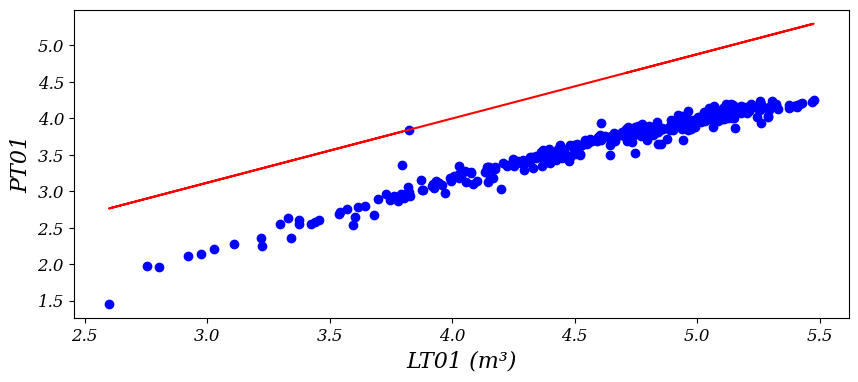

In [ ]:
# my_lm = LinearRegression()
# lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
# lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
# lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
# lm = my_lm.fit(X =endog_l, y = endog)
# lr_trn = lm_trn.predict(endog_l_trn+pv)
# lr_vld = lm_vld.predict(endog_l_vld+pv)
# lr_tst = lm_tst.predict(endog_l_tst+pv)
# lr = lm_tst.predict(endog_l+pv)

plt.figure(figsize = (10,4))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(endog_l_tst, endog_tst, color = 'b')
plt.plot(endog_l_tst, lr_tst, color = 'r')
plt.xlabel(f'{rt}',fontsize = 16)
plt.ylabel(f'PT01',fontsize = 16)
plt.savefig(f"LR {rt}.png", dpi=300)
plt.show()



Coeficiente R²: 0.3062


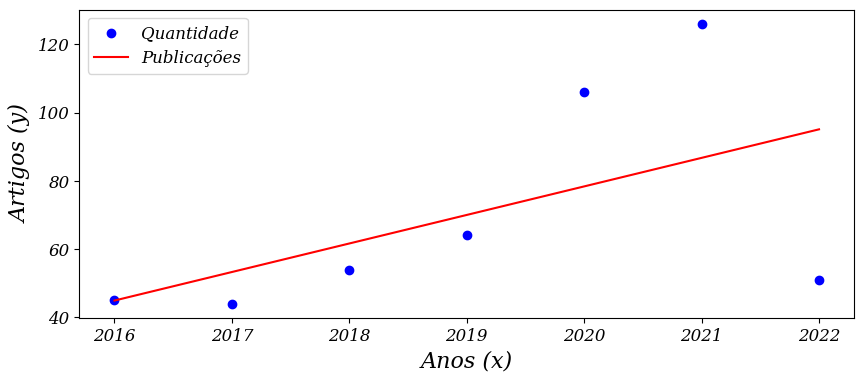

In [ ]:
rg = pd.read_csv('regressão linear.csv', sep = ';')
# rg.set_index('Ano', inplace = True)

X = rg[['Ano']]
Y = rg['quantidade de artigo']

rg1 = my_lm.fit(X, Y)
reg = rg1.predict(X)

r_squared = r2_score(Y, reg)
print(f'Coeficiente R²: {r_squared:2.4f}')

plt.figure(figsize = (10,4))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(X, Y, color = 'b')
plt.plot(X, reg, color = 'r')
plt.xlabel('Anos (x)',fontsize = 16)
plt.ylabel('Artigos (y)',fontsize = 16)
plt.legend(['Quantidade', 'Publicações'], loc='upper left')
plt.savefig("regressão linear dos artigos baseados nos anos.png", dpi=300)
plt.show()

# Cross Validation

In [ ]:
# opt = BayesSearchCV(
#     XGBRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [ ]:
# opt = XGBRegressor()
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [ ]:

# opt.fit(exog_trn, endog_trn)

In [ ]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(XGBRegressor(), param_space, n_iter=32,
#                                         scoring="accuracy", verbose=True, cv=5,
#                                         n_jobs=-1, random_state=42)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [6, 10],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [3, 5],
#      'min_samples_split': [4, 6],
#      'n_estimators': [100, 350]
#     }
     

# forest_clf = XGBRegressor()

# opt = GridSearchCV(forest_clf, param_grid, cv=5,
#                                   scoring="accuracy",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [ ]:
# param_grid = {'bootstrap': [True],
#      'max_depth': [6, 10],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [3, 5],
#      'min_samples_split': [4, 6],
#      'n_estimators': [100, 350]
#     }
     

# forest_clf = RandomForestRegressor()

# opt = GridSearchCV(forest_clf, param_grid, cv=5,
#                                   scoring="accuracy",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)



In [ ]:



# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
#                                         scoring="r2", verbose=True, cv=5,
#                                         n_jobs=-1, random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)


In [ ]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 20), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 10),
#         "min_samples_split": Integer(2, 10),
#         "n_estimators": Integer(100, 500)
#     }

# opt = BayesSearchCV(forest_clf, search_space, 
#        n_iter=32,
#        random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)

In [ ]:
# param_grid = {'bootstrap': [True],
#      'max_depth': [6, 10],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [3, 5],
#      'min_samples_split': [4, 6],
#      'n_estimators': [100, 350]
#     }
     

# forest_clf = XGBRegressor()

# opt = GridSearchCV(forest_clf, param_grid, cv=5,
#                                   scoring="accuracy",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)


In [ ]:




# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
#                                         random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)


In [ ]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 20), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 10),
#         "min_samples_split": Integer(2, 10),
#         "n_estimators": Integer(100, 500)
#     }

# opt = BayesSearchCV(forest_clf, search_space, n_iter=32,random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)

In [ ]:
# param_grid = {'bootstrap': [True],
#      'max_depth': [10, 800],
#      'max_features': ['auto', 'sqrt'],
#      'min_samples_leaf': [1, 300],
#      'min_samples_split': [300, 800],
#      'n_estimators': [50, 1000]
#     }
     

# forest_clf = LGBMRegressor()

# opt = GridSearchCV(forest_clf, param_grid, cv=5,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)


In [ ]:




# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(forest_clf, param_space, n_iter=32,random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)


In [ ]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 20), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 10),
#         "min_samples_split": Integer(2, 10),
#         "n_estimators": Integer(100, 500)
#     }

# opt = BayesSearchCV(forest_clf, search_space,  n_iter=32,random_state=42)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100)
# # print(opt.best_params_)
# # print(opt.best_estimator_)
# # print(opt.best_score_)

In [ ]:



crv(my_xgb, exog_trn, endog_trn, scoring = 'r2').mean()*100

95.62631611455824

In [ ]:
crv(my_lgbm, exog_trn, endog_trn, scoring = 'r2').mean()*100

95.70541227023647

In [ ]:
crv(my_lm, exog_trn, endog_trn, scoring = 'r2').mean()*100

95.15624843316145

In [ ]:
crv(my_rf, exog_trn, endog_trn, scoring = 'r2').mean()*100

96.4169525502087

#  comparação regressão 

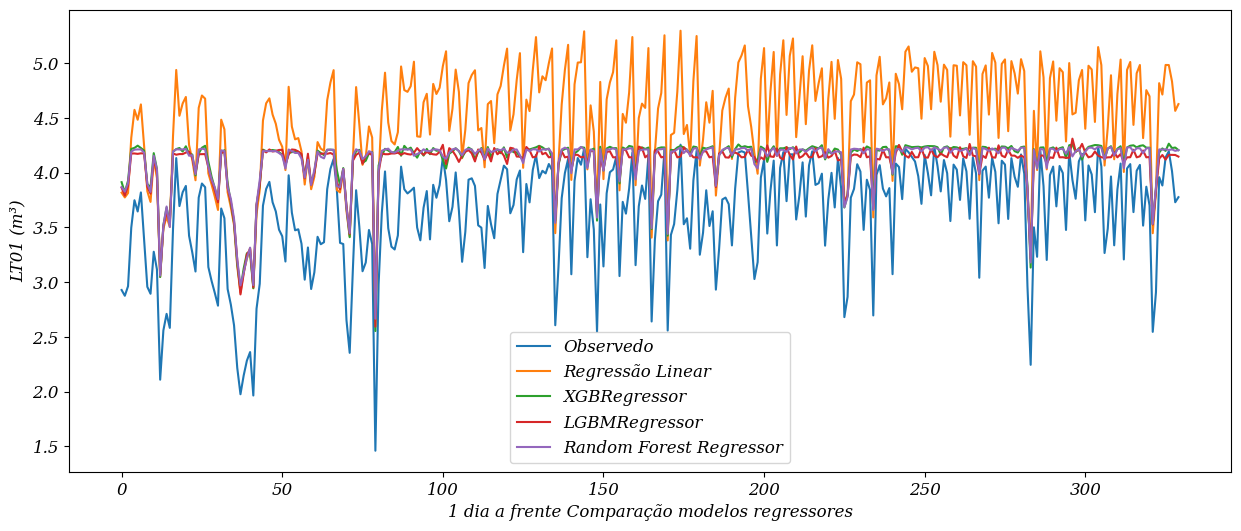

In [ ]:
# x = range(0,len(endog_tst),50)
# value = endog_tst.index[range(0,len(endog_tst),50)]
plt.figure(figsize = (15,6))
plt.plot(list(endog_tst))
plt.plot(list(lr_tst))
plt.plot(list(xgb_tst))
plt.plot(list(lgbm_tst))
plt.plot(list(rf_tst))
# plt.yticks(fontsize = 12)
# plt.xticks(x, value, fontsize = 10)
plt.xlabel(pvl+' Comparação modelos regressores', fontsize = 12)
plt.legend(['Observedo','Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Random Forest Regressor'])
plt.ylabel(rt)
plt.savefig(f"{pv}-LR-XGB-LGBM-RF.png", dpi=300)
plt.show()

In [ ]:
endog_tst.head(10)

Timestamp
2020-02-06    2.927480
2020-02-07    2.874942
2020-02-08    2.961961
2020-02-09    3.496335
2020-02-10    3.747986
2020-02-11    3.645145
2020-02-12    3.819269
2020-02-13    3.393618
2020-02-14    2.956659
2020-02-15    2.893192
Freq: 24H, Name: NIVEL DO RESERVATÓRIO - LT01, dtype: float64

In [ ]:
sarimax_tst.head(10)

2020-02-06    4.036520
2020-02-07    2.860523
2020-02-08    2.926807
2020-02-09    3.491724
2020-02-10    3.797083
2020-02-11    3.627606
2020-02-12    3.818006
2020-02-13    3.411360
2020-02-14    2.960707
2020-02-15    2.839063
Freq: 24H, Name: predicted_mean, dtype: float64

# Redes neurais

## LSTM

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow import keras

# n_samples = endog_trn.shape[0]
# n_timesteps = endog_trn.shape[0]
# n_steps = endog_trn.shape[0]
# n_features = 1

# # endog_trn_rs = endog_trn.reshape(n_samples, n_timesteps, n_features )
# # endog_tst_rs = endog_tst.reshape(endog_tst.shape[0], n_timesteps, n_features )

# random.seed(42)
# batch_size = 32
# simple_model = Sequential([LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),Dense(endog_trn.shape[0])])
# simple_model.summary()
# simple_model.compile(
# optimizer=keras.optimizers.Adam(learning_rate=0.01),
# loss='mean_absolute_error',
# metrics=['mean_absolute_error'],
# )
# smod_history = simple_model.fit(endog_trn, endog_trn,
#                                 validation_split=0.2,
#                                 epochs=5,
#                                 batch_size=batch_size,
#                                 shuffle = True)
                                
# preds = simple_model.predict(endog_tst)
# print(r2_score(preds, endog_tst))
# plt.plot(smod_history.history['loss'])
# plt.plot(smod_history.history['val_loss'])
# plt.title('model loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()



In [ ]:
# import keras
# import pandas as pd
# from zipfile import ZipFile
# import os
# uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
# zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
# zip_file = ZipFile(zip_path)
# zip_file.extractall()
# csv_path = "jena_climate_2009_2016.csv"
# df = pd.read_csv(csv_path)
# del zip_file
# # retain only temperature
# df = df[['T (degC)']]
# # apply a min max scaler
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])
# # convert to windowed data sets
# ylist = list(df['T'])
# n_future = 72
# n_past = 3*72
# total_period = 4*72
# idx_end = len(ylist)
# idx_start = idx_end - total_period

In [ ]:
# X_new = []
# y_new = []
# while idx_start > 0:
#     x_line = ylist[idx_start:idx_start+n_past]
#     y_line = ylist[idx_start+n_past:idx_start+total_period]
#     X_new.append(x_line)
#     y_new.append(y_line)
#     idx_start = idx_start - 1
# import numpy as np
# X_new = np.array(X_new)
# y_new = np.array(y_new)
# # train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
#                                                     test_size=0.33, random_state=42)
# # reshape data into the right format for RNNs
# n_samples = X_train.shape[0]
# n_timesteps = X_train.shape[1]
# n_steps = y_train.shape[1]
# n_features = 1
# X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
# X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

In [ ]:
# import random
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# random.seed(42)
# batch_size = 32
# simple_model = Sequential([
# LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
# Dense(y_train.shape[1]),
# ])
# simple_model.summary()
# simple_model.compile(
# optimizer=keras.optimizers.Adam(learning_rate=0.01),
# loss='mean_absolute_error',
# metrics=['mean_absolute_error'],
# )
# smod_history = simple_model.fit(X_train_rs, y_train,
# validation_split=0.2,
# epochs=5,
# batch_size=batch_size,
# shuffle = True
# )
# preds = simple_model.predict(X_test_rs)
# print(r2_score(preds, y_test))
# plt.plot(smod_history.history['loss'])
# plt.plot(smod_history.history['val_loss'])
# plt.title('model loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# Salva Erro


In [ ]:
hora = '24h'


In [ ]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_trn, mape_ARX_trn, mape_MA_trn ,mape_ARMA_trn, 
        mape_ARIMA_trn,mape_SARIMA_trn, mape_arimax_trn,mape_sarimax_trn, mape_lr_trn, mape_rf_trn, mape_xgb_trn, 
        mape_lgbm_trn],
        'MAE':[ mae_AR_trn, mae_ARX_trn, mae_MA_trn, mae_ARMA_trn,mae_ARIMA_trn,
        mae_SARIMA_trn, mae_arimax_trn, mae_sarimax_trn, mae_lr_trn, mae_rf_trn, mae_xgb_trn, mae_lgbm_trn],
        'RMSE':[ rmse_AR_trn, rmse_ARX_trn, rmse_MA_trn, rmse_ARMA_trn,rmse_ARIMA_trn,
        rmse_SARIMA_trn,rmse_arimax_trn, rmse_sarimax_trn, rmse_lr_trn, rmse_rf_trn, rmse_xgb_trn, rmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,9.645,30.560,41.924
ARX,11.845,37.725,51.291
MA,9.335,29.574,40.253
ARMA,10.181,32.514,43.563
ARIMA,9.494,30.268,40.596
SARIMA,9.964,32.182,42.692
ARIMAX,11.858,37.759,51.144
SARIMAX,11.830,37.685,51.222
Linear Regression,1.546,6.865,7.716
Random Forest Regressor,18.995,62.279,67.060


In [ ]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'MAPE':[ mape_AR_vld, mape_ARX_vld, mape_MA_vld, mape_ARMA_vld,mape_ARIMA_vld,
        mape_SARIMA_vld,mape_arimax_vld, mape_sarimax_vld, mape_lr_vld, mape_rf_vld, mape_xgb_vld, mape_lgbm_vld],
        'MAE':[ mae_AR_vld, mae_ARX_vld, mae_MA_vld, mae_ARMA_vld,mae_ARIMA_vld,
        mae_SARIMA_vld, mae_arimax_vld, mae_sarimax_vld, mae_lr_vld, mae_rf_vld, mae_xgb_vld, mae_lgbm_vld],
        'RMSE':[rmse_AR_vld, rmse_ARX_vld, rmse_MA_vld, rmse_ARMA_vld,rmse_ARIMA_vld,
        rmse_SARIMA_vld,rmse_arimax_vld, rmse_sarimax_vld, rmse_lr_vld, rmse_rf_vld, rmse_xgb_vld, rmse_lgbm_vld],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,8.397,28.469,36.552
ARX,10.262,35.365,45.938
MA,8.217,27.830,36.055
ARMA,8.672,29.709,37.355
ARIMA,8.156,27.880,34.899
SARIMA,9.271,31.796,41.235
ARIMAX,10.239,35.281,45.837
SARIMAX,10.377,35.794,46.291
Linear Regression,1.426,6.568,7.283
Random Forest Regressor,17.218,58.677,63.150


In [ ]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {   
      
        'MAPE': [mape_AR_tst, mape_ARX_tst, mape_MA_tst, mape_ARMA_tst,mape_ARIMA_tst,
        mape_SARIMA_tst,mape_arimax_tst, mape_sarimax_tst, mape_lr_tst, mape_rf_tst, mape_xgb_tst, mape_lgbm_tst],
        'MAE': [mae_AR_tst, mae_ARX_tst, mae_MA_tst, mae_ARMA_tst,mae_ARIMA_tst,
        mae_SARIMA_tst, mae_arimax_tst, mae_sarimax_tst, mae_lr_tst, mae_rf_tst, mae_xgb_tst, mae_lgbm_tst],
        'RMSE':[rmse_AR_tst, rmse_ARX_tst, rmse_MA_tst, rmse_ARMA_tst,rmse_ARIMA_tst,
        rmse_SARIMA_tst,rmse_arimax_tst,rmse_sarimax_tst, rmse_lr_tst, rmse_rf_tst, rmse_xgb_tst, rmse_lgbm_tst],
    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros teste.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,9.968,32.881,42.404
ARX,13.734,46.150,58.618
MA,10.187,33.613,43.104
ARMA,10.120,33.751,43.015
ARIMA,10.412,34.898,44.475
SARIMA,11.326,37.933,47.740
ARIMAX,13.729,46.113,58.659
SARIMAX,13.761,46.233,58.733
Linear Regression,1.838,8.657,9.845
Random Forest Regressor,15.217,49.198,58.514


In [ ]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        "MAPE": [AR_mape, ARX_mape, MA_mape, ARMA_mape, ARIMA_mape, SARIMA_mape, arimax_mape, sarimax_mape, mape_lr, mape_rf,
         mape_xgb, mape_lgbm],


        "MAE": [AR_mae, ARX_mae, MA_mae, ARMA_mae, ARIMA_mae, SARIMA_mae, arimax_mae, sarimax_mae, mae_lr, mae_rf, mae_xgb, mae_lgbm],


        'RMSE': [ AR_rmse, ARX_rmse, MA_rmse ,ARMA_rmse, ARIMA_rmse, SARIMA_rmse, arimax_rmse, sarimax_rmse, rmse_lr, rmse_rf, 
        rmse_xgb, rmse_lgbm],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_erro


,MAPE,MAE,RMSE
AR,9.326,30.241,16.502
ARX,12.276,40.217,28.304
MA,10.669,34.408,45.957
ARMA,9.749,31.590,42.367
ARIMA,9.487,30.724,41.136
SARIMA,9.943,32.657,42.535
ARIMAX,12.039,39.440,52.124
SARIMAX,12.249,40.120,53.071
Linear Regression,1.617,7.363,8.360
Random Forest Regressor,17.609,57.837,64.053



# Teste significancia


In [ ]:

from scipy import stats

#faça o teste de Friedman
friendma = stats.friedmanchisquare(df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA- FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02'])

print(friendma)

import scikit_posthocs as sp

#combine three groups into one array
data = np.array([df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA- FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02']])

#perform Nemenyi post-hoc test
print(sp.posthoc_nemenyi_friedman(data.T))



FriedmanchisquareResult(statistic=8015.610533599998, pvalue=0.0)
      0     1     2     3     4     5     6     7     8
0 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
1 0.001 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.157
2 0.001 0.001 1.000 0.847 0.001 0.001 0.001 0.001 0.001
3 0.001 0.001 0.847 1.000 0.001 0.001 0.001 0.001 0.001
4 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001 0.001
5 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001
6 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001
7 0.001 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001
8 0.001 0.157 0.001 0.001 0.001 0.001 0.001 0.001 1.000


# Ljung Box

In [ ]:
ar1 = str(lj_ar_df)
arx1 = str(lj_arx_df)
ma1 = str(lj_ma_df)
arma1 = str(lj_arma_df)
arima1 = str(lj_arima_df)
arimax1 = str(lj_arimax_df)
sarima1 = str(lj_sarima_df)
sarimax1 = str(lj_sarimax_df)


In [ ]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,4.703,0.910
AR,4.262,0.161
MA,49.158,0.000
ARMA,40.489,0.000
ARIMA,40.489,0.000
SARIMA,40.489,0.000
ARIMAX,61.355,0.000
SARIMAX,6.130,0.804


In [ ]:
ar1 = str(lj_ar_trn)
arx1 = str(lj_arx_trn)
ma1 = str(lj_ma_trn)
arma1 = str(lj_arma_trn)
arima1 = str(lj_arima_trn)
arimax1 = str(lj_arimax_trn)
sarima1 = str(lj_sarima_trn)
sarimax1 = str(lj_sarimax_trn)


In [ ]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_trn.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,6.297,0.790
AR,7.125,0.072
MA,34.340,0.000
ARMA,11.533,0.318
ARIMA,13.173,0.214
SARIMA,8.403,0.590
ARIMAX,30.400,0.001
SARIMAX,10.903,0.365


In [ ]:
ar1 = str(lj_ar_tst)
arx1 = str(lj_arx_tst)
ma1 = str(lj_ma_tst)
arma1 = str(lj_arma_tst)
arima1 = str(lj_arima_tst)
arimax1 = str(lj_arimax_tst)
sarima1 = str(lj_sarima_tst)
sarimax1 = str(lj_sarimax_tst)


In [ ]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_tst.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,0.857,1.000
AR,7.795,0.649
MA,7.886,0.640
ARMA,19.148,0.038
ARIMA,7.242,0.702
SARIMA,5.044,0.888
ARIMAX,0.597,1.000
SARIMAX,3.016,0.981


In [ ]:
ar1 = str(lj_ar_vld)
arx1 = str(lj_arx_vld)
ma1 = str(lj_ma_vld)
arma1 = str(lj_arma_vld)
arima1 = str(lj_arima_vld)
arimax1 = str(lj_arimax_vld)
sarima1 = str(lj_sarima_vld)
sarimax1 = str(lj_sarimax_vld)


In [ ]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_vld.xlsx')
ljung


,Estatística de Teste,Valor De p
ARX,7.468,0.681
AR,2.428,0.992
MA,1.387,0.999
ARMA,5.229,0.875
ARIMA,4.083,0.944
SARIMA,7.184,0.708
ARIMAX,0.021,1.000
SARIMAX,0.043,1.000
